In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '..','..','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/causal-cmd-1.2.0-SNAPSHOT-jar-with-dependencies.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '..','..','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [7]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [8]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Double")(dframe.iloc[row,col])
        dataBox.set(row,col,value)

In [9]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [10]:
numLags = 1
tetradData = javabridge.static_call('edu/cmu/tetrad/search/TimeSeriesUtils',
                                    'createLagData',
                                    '(Ledu/cmu/tetrad/data/DataSet;I)Ledu/cmu/tetrad/data/DataSet;', 
                                    boxData, numLags)

In [11]:
alpha = 0.05
IndTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestFisherZ')(tetradData, alpha)

In [12]:
penaltydiscount = 2 # set to 2 if variable# <= 50 otherwise set it to 4
score = javabridge.JClassWrapper('edu.cmu.tetrad.search.SemBicScore')(tetradData)
score.setPenaltyDiscount(penaltydiscount) 

In [13]:
tsgfci = javabridge.JClassWrapper('edu.cmu.tetrad.search.TsGFci')(IndTest, score)

In [14]:
tsgfci.setMaxIndegree(3)
tsgfci.setMaxPathLength(-1)
tsgfci.setCompleteRuleSetUsed(False)
tsgfci.setFaithfulnessAssumed(True)
tsgfci.setVerbose(True)

In [15]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.addToTier(0, 'AmountDonated:1')
prior.addToTier(0, 'Imaginability:1')
prior.addToTier(0, 'Impact:1')
prior.addToTier(0, 'Sympathy:1')
prior.addToTier(0, 'TangibilityCondition:1')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(1, 'Imaginability')
prior.addToTier(1, 'Impact')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'TangibilityCondition')
tsgfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

1  AmountDonated:1 Imaginability:1 Impact:1 Sympathy:1 TangibilityCondition:1
2  AmountDonated Imaginability Impact Sympathy TangibilityCondition

forbiddirect

requiredirect

In [16]:
tetradGraph = tsgfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
TangibilityCondition;AmountDonated;Sympathy;Imaginability;Impact;TangibilityCondition:1;AmountDonated:1;Sympathy:1;Imaginability:1;Impact:1

Graph Edges:
1. Impact --> Imaginability dd nl
2. Impact --> Sympathy dd nl
3. Impact:1 --> Imaginability:1 dd pl
4. Impact:1 --> Sympathy:1 dd pl
5. AmountDonated:1 o-> AmountDonated
6. AmountDonated:1 o-> Impact
7. TangibilityCondition:1 o-> Sympathy
8. TangibilityCondition:1 o-> TangibilityCondition


In [17]:
tetradGraph.toString()

'Graph Nodes:\nTangibilityCondition;AmountDonated;Sympathy;Imaginability;Impact;TangibilityCondition:1;AmountDonated:1;Sympathy:1;Imaginability:1;Impact:1\n\nGraph Edges:\n1. Impact --> Imaginability dd nl\n2. Impact --> Sympathy dd nl\n3. Impact:1 --> Imaginability:1 dd pl\n4. Impact:1 --> Sympathy:1 dd pl\n5. AmountDonated:1 o-> AmountDonated\n6. AmountDonated:1 o-> Impact\n7. TangibilityCondition:1 o-> Sympathy\n8. TangibilityCondition:1 o-> TangibilityCondition\n\n'

In [18]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [TangibilityCondition, AmountDonated, Sympathy, Imaginability, Impact, TangibilityCondition:1, AmountDonated:1, Sympathy:1, Imaginability:1, Impact:1]

In [19]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [Impact --> Sympathy dd nl, TangibilityCondition:1 o-> Sympathy, AmountDonated:1 o-> Impact, AmountDonated:1 o-> AmountDonated, Impact:1 --> Imaginability:1 dd pl, Impact:1 --> Sympathy:1 dd pl, TangibilityCondition:1 o-> TangibilityCondition, Impact --> Imaginability dd nl]

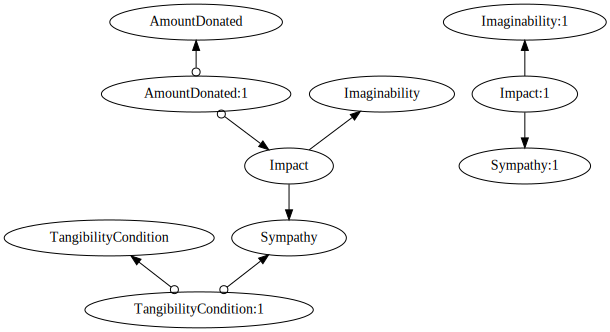

In [20]:
dot_str = javabridge.static_call('edu/cmu/tetrad/graph/GraphUtils',
                                   'graphToDot',
                                   '(Ledu/cmu/tetrad/graph/Graph;)Ljava/lang/String;', 
                                   tetradGraph)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()
SVG(svg_str)

In [21]:
javabridge.detach()
javabridge.kill_vm()